# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 3. Визуальный анализ данных и построение признаков

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
import arrow
from re import search

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [5]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as fp:
        dictionary = pickle.load(fp)
    for key, value in dictionary.items():
        dictionary[key] = value[0]
    data = []
    for filename in sorted(glob(path_to_csv_files + '/*.csv')):
        # Find user index.
        user_index = int(search(r'([0-9]{4})', filename).group())
        current_user = pd.read_csv(filename)
        current_value = list(current_user['site'].values)
        timestamp = current_user['timestamp'].values
        data_time = []
        # Save all dates.
        for d_t in timestamp:
            data_time.append(arrow.get(d_t).datetime)
        start = 0
        finish = session_length
        while start < len(current_value):
            #If current_value[start] = '0' means this user haven`t sites anymore.
            if current_value[start] == '0':
                break
            if finish > len(current_value):
                c = current_value.copy() + ['0'] * (finish - len(current_value))
                d = data_time + [data_time[-1]] * (finish - len(current_value))
                current_value = c.copy()
                data_time = d.copy()
            sites = list(current_value[start: finish])
            time_difference = [value.seconds for value 
                              in np.array(data_time[start + 1:finish]) - np.array(data_time[start:finish-1])]
            session_timestamp = sum(time_difference)
            unique = len(set(sites)) if '0' not in sites else len(set(sites))-1
            day_of_week =data_time[start].weekday()
            start_hour = data_time[start].hour
            target = user_index
            data.append(sites+time_difference+[session_timestamp, unique, start_hour, day_of_week, target])
            start = start + window_size
            finish = finish + window_size
    data = pd.DataFrame(data, columns=feature_names)
    for column in [f'site{x}' for x in range(1, session_length+1)]:
        data[column] = data[column].map(dictionary)
    data = data.fillna(int(0))
    data = data.astype(int)
    return data

**Проверим функцию на игрушечном примере.**

In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [7]:
train_data_toy.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [5]:
#проверочная ячейка
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 41.2 s, sys: 188 ms, total: 41.4 s
Wall time: 41.4 s


In [9]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [10]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 6min 38s, sys: 1.15 s, total: 6min 39s
Wall time: 6min 40s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [11]:
need_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
new_features_10users = train_data_10users[need_features]
new_features_150users = train_data_150users[need_features]

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [13]:
print(new_features_10users['session_timespan'].median())

37.0


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [14]:
print(new_features_10users['day_of_week'].median())

2.0


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [15]:
print(new_features_150users['start_hour'].median())

13.0


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [16]:
print(new_features_150users['#unique_sites'].median())

7.0


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [17]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [18]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

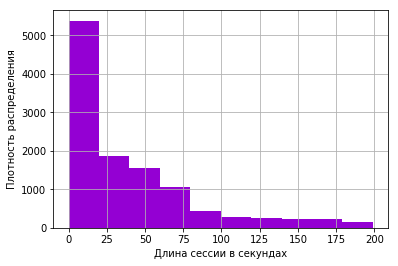

In [19]:
session = train_data_10users[train_data_10users['session_timespan'] < 200]['session_timespan'].hist(color = 'darkviolet')
session.set_xlabel("Длина сессии в секундах")
session.set_ylabel("Плотность распределения");

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

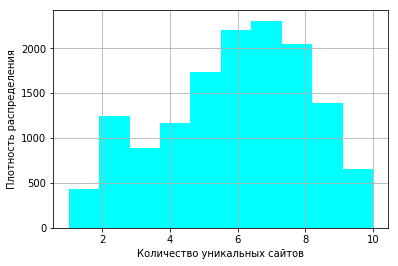

In [20]:
unique = train_data_10users['#unique_sites'].hist(color = 'aqua')
unique.set_xlabel("Количество уникальных сайтов")
unique.set_ylabel("Плотность распределения");

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

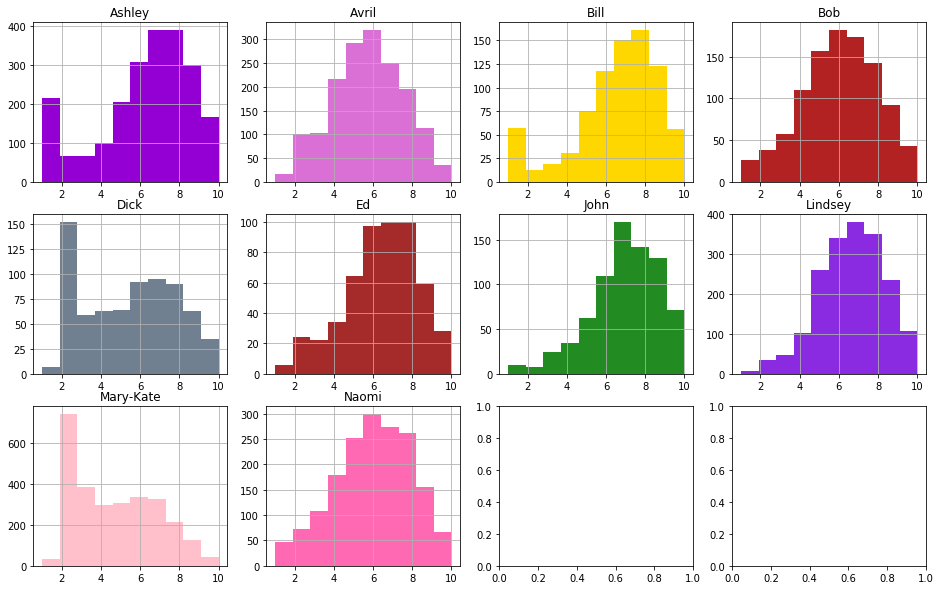

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    sub_df['#unique_sites'].hist(color = color_dic[user], ax=axes[idx//4,idx%4])
    axes[idx//4,idx%4].set_title(user)

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

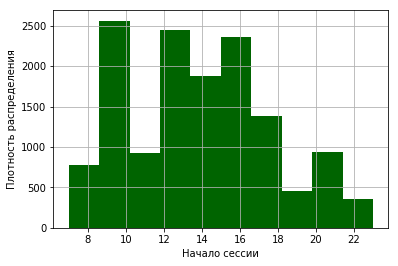

In [22]:
unique = train_data_10users['start_hour'].hist(color = 'darkgreen')
unique.set_xlabel("Начало сессии")
unique.set_ylabel("Плотность распределения");

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

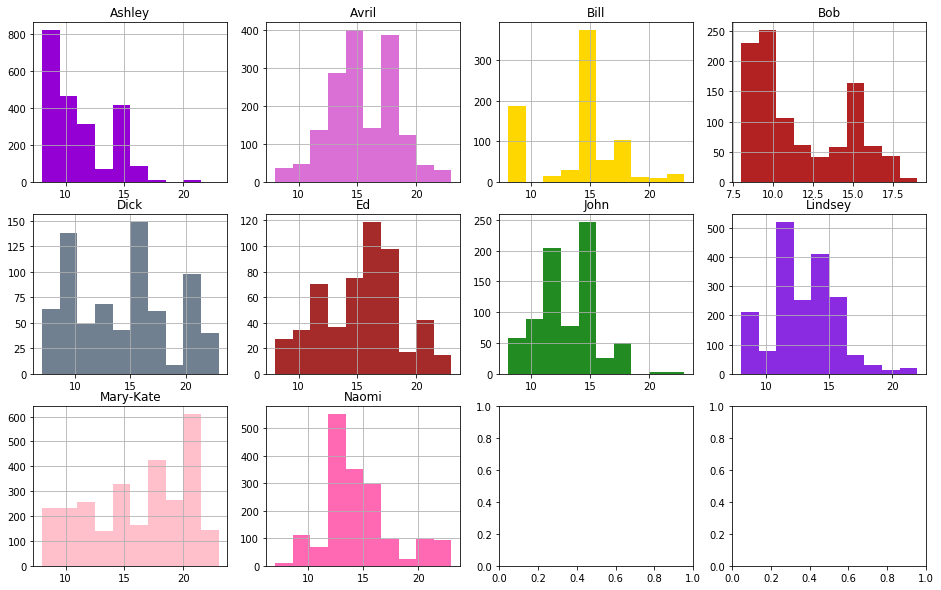

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    sub_df['start_hour'].hist(color = color_dic[user], ax=axes[idx//4,idx%4])
    axes[idx//4,idx%4].set_title(user)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

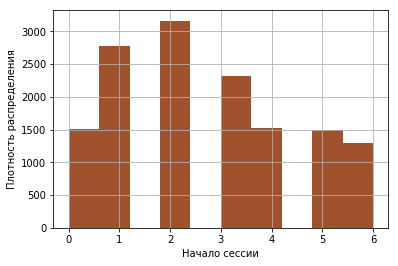

In [24]:
unique = train_data_10users['day_of_week'].hist(color = 'sienna')
unique.set_xlabel("Начало сессии")
unique.set_ylabel("Плотность распределения");

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

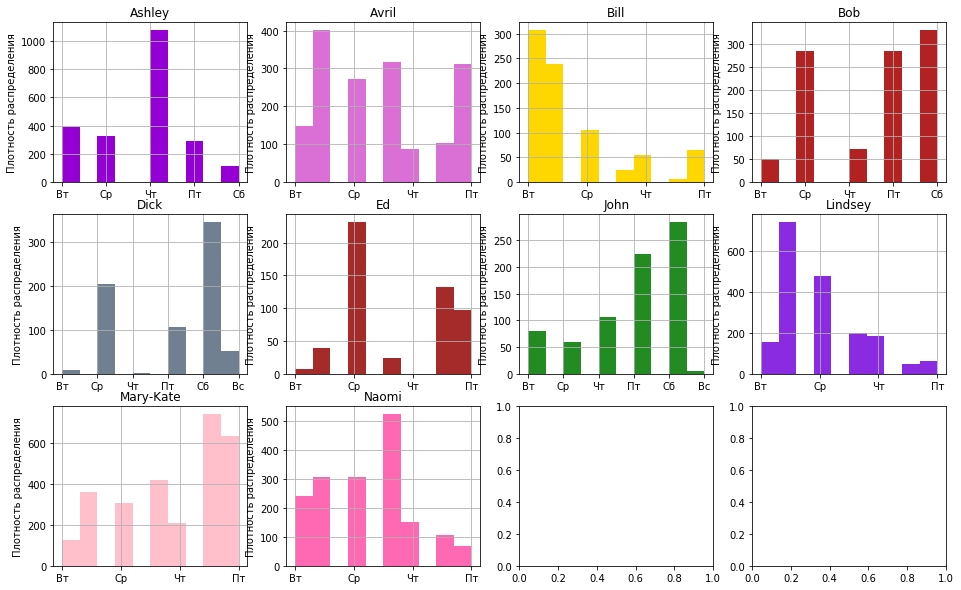

In [25]:
x_label = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    sub_df['day_of_week'].hist(color = color_dic[user], ax=axes[idx//4,idx%4])
    axes[idx//4,idx%4].set_ylabel("Плотность распределения");
    axes[idx//4,idx%4].set_xticklabels(x_label)
    axes[idx//4,idx%4].set_title(user)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

С первого графика видно, что большее количество сессии длится около 25 секунд. Зная то, что сессия это 10 сайтов можно сказать, что люди в нашем наборе из 10 человек открывают очень много сайтов. Может, к примеру, они ищут какую-то информацию на работе. Уникальное количество сайтов при этом от 6 к 8. Я себе представляю это так: человек ищет какую-то информацию и открывает ссылки, которые ему посоветовал поисковый сервис. Какая-то информация ему подошла больше и он возвращается к ней. Всё логично. Конечно, есть и такие случаи когда в сессии пару уникальных сайтов. Это может говорить о том, что человек переключается с одной вкладки на другую, скорее всего он просто открывает тот же сайт на котором смотрит сериал, или читает новости. Такими людьми в нашие наборе являются Mary-Kate, Dick. А все остальные скорее ищут информацию, хотя, у них тоже есть сайты, которые они открывают очень много раз за сессию. График плотности распределения по началу сессии наибольший с 9 к 10 часам или с 12 к 16. Я предполагаю, что это время прихода на работу и, к примеру, время обеда. Так же по часам начала сесии можно посмотреть наибольше пользуется компьютером днём, в рабочее время(Боб, Джон, Линси), а кто много пользуется им вечером, скорее всего дома(Мери-Кейт). Так же график распределения дней недели по всем нам дал неоднозначный результат, но при построении графиков для каждого человека стало очевидным, что все пользуются наименьше компьютером(точнее интернетом) в будние дни, особенно в среду, но есть и пару человек, которые пользуются интернетом на выходных. 

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [26]:
with open(PATH_TO_DATA+'/site_freq_10users.pkl', 'rb') as fp:
        site_freq_10users = pickle.load(fp)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [27]:
top10_sites = [key for key, value in site_freq_10users.items()][:10]
top10_freqs = [value[1] for key, value in site_freq_10users.items()][:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

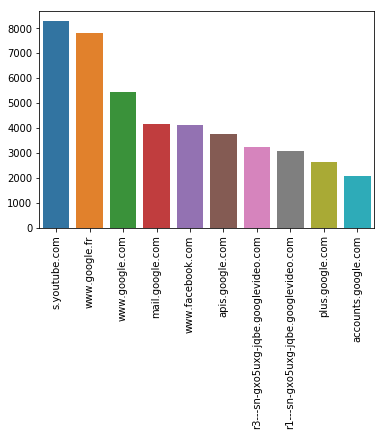

In [28]:
top = sns.barplot(x=top10_sites, y=top10_freqs)
top.set_xticklabels(top.get_xticklabels(), rotation=90);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [45]:
def feature_engineering(path_to_csv_files, features, site_freq_path, window_size=10, session_length=10):
    with open(site_freq_path, 'rb') as fp:
        dictionary = pickle.load(fp)
    top15_sites = [key for key, value in dictionary.items()][:15]
    for key, value in dictionary.items():
        dictionary[key] = value[0]
    data = []
    day = {1:(4, 12), 2:(12, 15), 3:(15, 21), 4:(21, 23), 5:(0, 4)}
    year = {1:(12, 1, 2), 2:(3, 4, 5), 3:(6, 7, 8), 4:(9, 10, 11)}
    for filename in sorted(glob(path_to_csv_files + '/*.csv')):
        # Find user index.
        user_index = int(search(r'([0-9]{4})', filename).group())
        current_user = pd.read_csv(filename)
        current_value = list(current_user['site'].values)
        timestamp = current_user['timestamp'].values
        data_time = []
        # Save all dates.
        for d_t in timestamp:
            data_time.append(arrow.get(d_t).datetime)
        start = 0
        finish = session_length
        while start < len(current_value):
            #If current_value[start] = '0' means this user haven`t sites anymore.
            if current_value[start] == '0':
                break
            if finish > len(current_value):
                c = current_value.copy() + ['0'] * (finish - len(current_value))
                d = data_time + [data_time[-1]] * (finish - len(current_value))
                current_value = c.copy()
                data_time = d.copy()
            sites = list(current_value[start: finish])
            time_difference = [value.seconds for value 
                              in np.array(data_time[start + 1:finish]) - np.array(data_time[start:finish-1])]
            session_timestamp = sum(time_difference)
            unique = len(set(sites)) if '0' not in sites else len(set(sites))-1
            day_of_week =data_time[start].weekday()
            start_hour = data_time[start].hour
            time_of_day = [key for key, value in day.items() if start_hour>value[0] and start_hour<=value[1]]
            time_of_year = [key for key, value in year.items() if data_time[start].month in value]
            weekend = 1 if day_of_week in [5, 6] else 0
            time_top = sum([1 for x in sites if x in top15_sites])
            time_google = sum([1 for x in sites if x == 'www.google.com'])
            target = user_index
            data.append(sites + time_difference + [session_timestamp, unique, start_hour, day_of_week]
                                               + time_of_day + time_of_year + [weekend, time_top, time_google, target])
            start = start + window_size
            finish = finish + window_size
    data = pd.DataFrame(data, columns=feature_names)
    for column in [f'site{x}' for x in range(1, session_length+1)]:
        data[column] = data[column].map(dictionary)
    data = data.fillna(int(0))
    data = data.astype(int)
    return data

Я решила добавить такие признаки: 
    - какое время дня(утро, обед, вечерь, ночь) в начале сессии;
    - какое время года(зима, весна, лето, осень) в начале сессии;
    - в выходной день или нет начало сессии;
    - как часто посещал сайты из топ-15 сайтов для своего набора данных;
    - как часто пользовался гуглом пользователь во время сессии.
Посмотрим на результат.

In [46]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'part_of_day', 'time_of_year', 'weekend', 'visit_top', 'visit_google', 'target']

In [47]:
%%time
new_features_10users  = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  features=feature_names, session_length=10)

CPU times: user 41.4 s, sys: 95.9 ms, total: 41.5 s
Wall time: 41.6 s


In [48]:
%%time
new_features_150users  = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  features=feature_names, session_length=10)

CPU times: user 6min 39s, sys: 752 ms, total: 6min 40s
Wall time: 6min 40s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Для начала так как и в предыдущем задании я добавлю для набора из 10 данных имена и дам каждому из них цвета.

In [49]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [50]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

Теперь можно приступать к анализу.

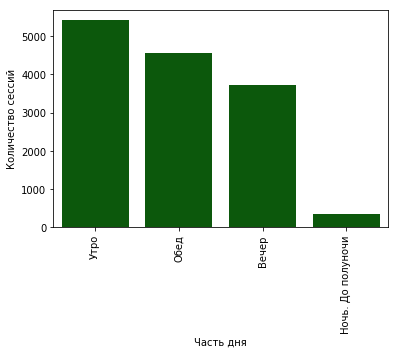

In [52]:
x_label_time_of_day = ['Утро', 'Обед', 'Вечер', 'Ночь. До полуночи', 'Ночь. После полуночи']

part_day = sns.countplot(x = 'part_of_day', data = new_features_10users, color = 'darkgreen')
part_day.set_xlabel("Часть дня");
part_day.set_ylabel("Количество сессий")
part_day.set_xticklabels(x_label_time_of_day)
part_day.set_xticklabels(part_day.get_xticklabels(), rotation=90);

Посмотрев на этот рисунок можно смело сказать что наибольшее количество сесий припадает на утро. Наверное, это связано с тем, что утром перед работой или во время работы люди читают новости, ищут какую-то информацию. И совсем малое количество пользуется интернетом ночью. Можно посмотреть кто это.

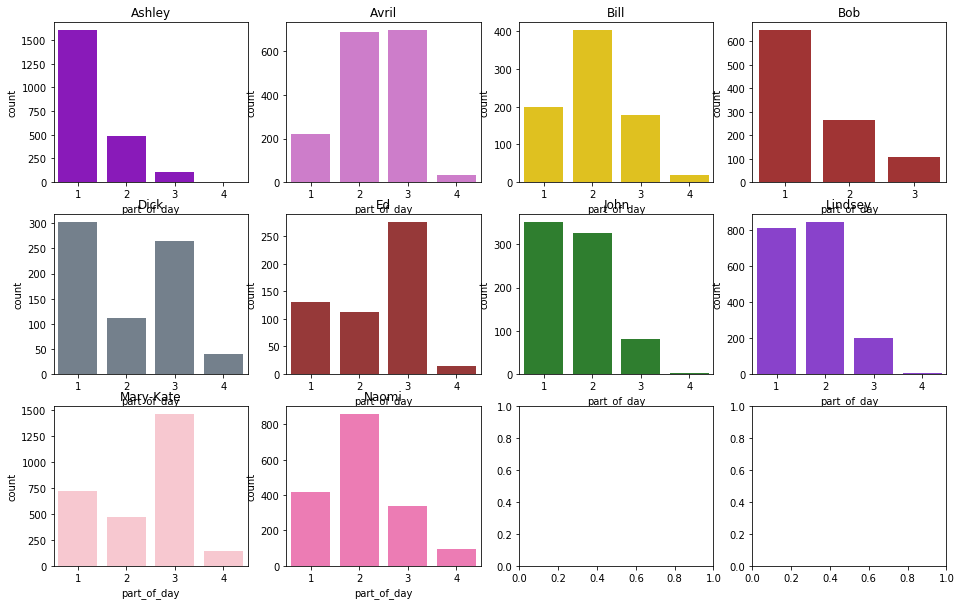

In [53]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    sns.countplot(x = 'part_of_day', data = sub_df, color = color_dic[user], ax=axes[idx//4,idx%4])
    axes[idx//4,idx%4].set_title(user)

Видно, что Боб совсем не пользуется интернетом ночью. 

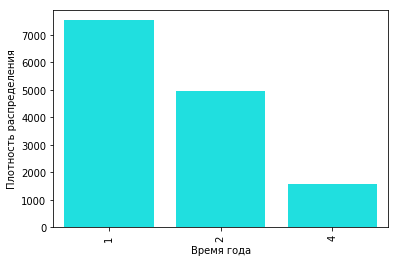

In [54]:
x_label_time_year = ['Зима', 'Весна', 'Лето', 'Осень']

time_year = sns.countplot(x = 'time_of_year', data = new_features_10users, color = 'aqua')
time_year.set_xlabel("Время года");
time_year.set_ylabel("Плотность распределения")
time_year.set_xticklabels(time_year.get_xticklabels(), rotation=90);

Посмотрев на этот график можно заметить, что у нас совсем нету колонки с цифрой 3. Это лето. Видно, у нас набор данных с какой-то очень хорошей фирмы, которая не заставляет людей работать летом и летом они отдыхают ;) 

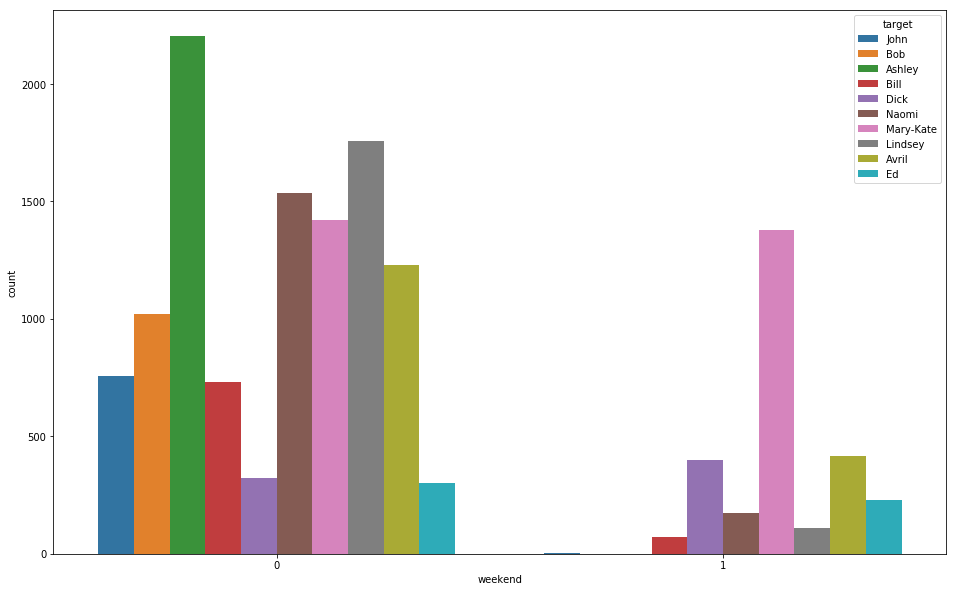

In [60]:
plt.figure(figsize=(16, 10))
sns.countplot(x='weekend', hue = 'target', data = new_features_10users);

Показал нам какое количество сессий было в выходной день. В выходной наибольше пользуется интернетом Мери-Кейт, а в будние дни Ешли.

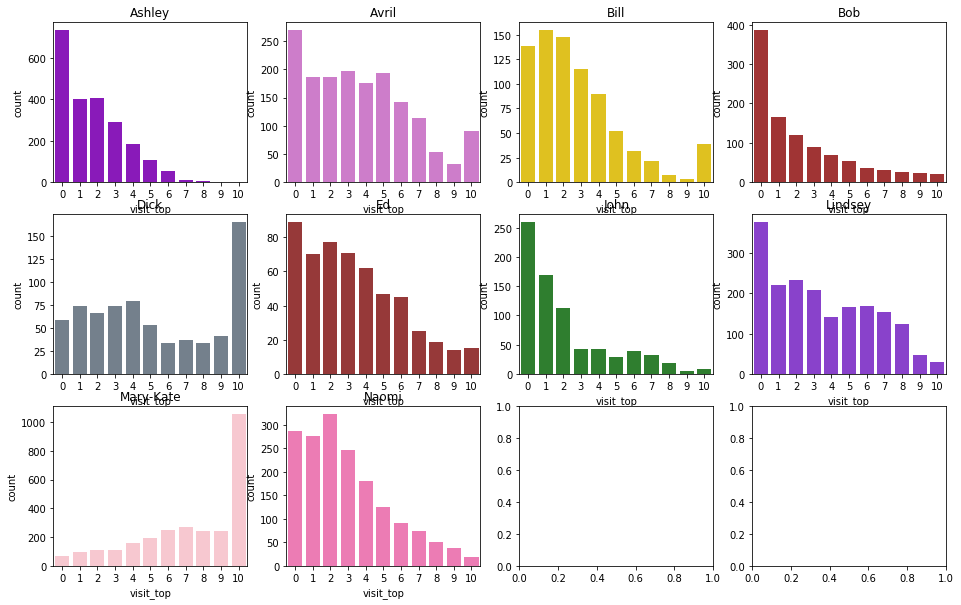

In [62]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    sns.countplot(x = 'visit_top', data = sub_df, color = color_dic[user], ax=axes[idx//4,idx%4])
    axes[idx//4,idx%4].set_title(user)

Эти графики показывают в каком количестве каждый из людей посещал сайты из топ-15. Наименьше посещают такие сайты Боб и Эшли. А вот Мери-Кейт и Дик часто заходят на такие сайты. Можно предположить, что Мери-Кейт любит на выходных посмотреть ютуб или посидеть в фейбуке. А так, как Дик работает больше в будние дни, то можно предположить, что он пользуется интернетом больше для работы и ищет там подсказки.

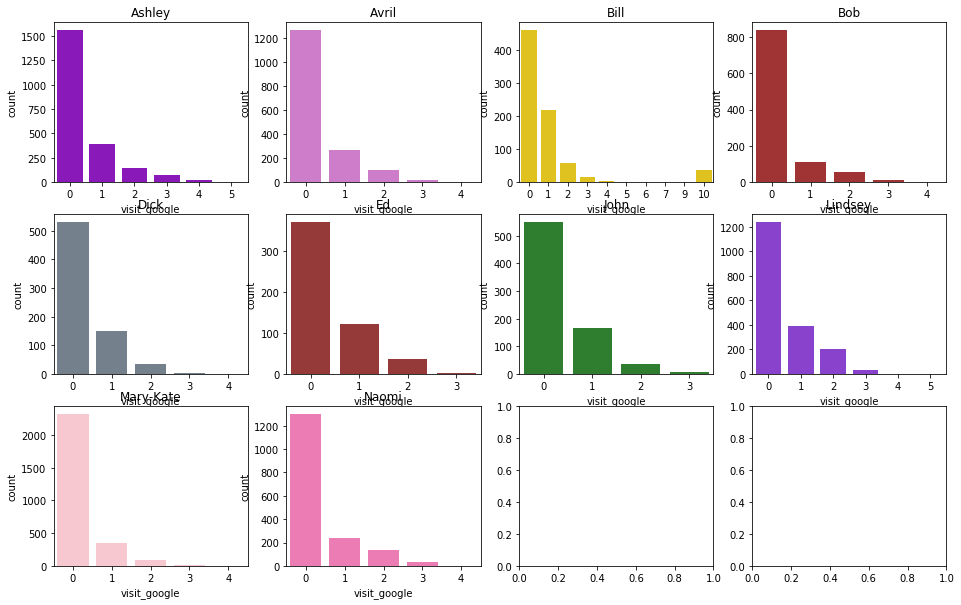

In [63]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')):
    sns.countplot(x = 'visit_google', data = sub_df, color = color_dic[user], ax=axes[idx//4,idx%4])
    axes[idx//4,idx%4].set_title(user)

Посмотрев на эти графики видно, что сотрудники мало пользуются гуглом. Но думаю эта колонка не будет особо информативной, так как значения у всех почти одинаковые.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [65]:
need_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'part_of_day', 'weekend', 'visit_top']
selected_features_10users = new_features_10users[need_features]
selected_features_150users = new_features_150users[need_features]

In [66]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)